# 汽车里程数回归预测实验

本实验以开源的auto-mpg数据集为基础，基于MindSpore深度学习库应用全连接神经网络进行汽车里程数预测。

## 1、实验目的

- 掌握全连接神经网络的原理。
- 了解如何使用MindSpore进行简单的回归模型的训练。
- 了解如何使用MindSpore进行简单的回归模型的预测。

## 2、全连接神经网络的原理介绍

浅层神经网络相比单层网络的差别在于隐藏层有多个神经节点，这就使得其可以处理“多输入多输出”的复杂问题。每一层的每一个节点都与上下层节点全部连接，这种神经网络称作全连接网络。

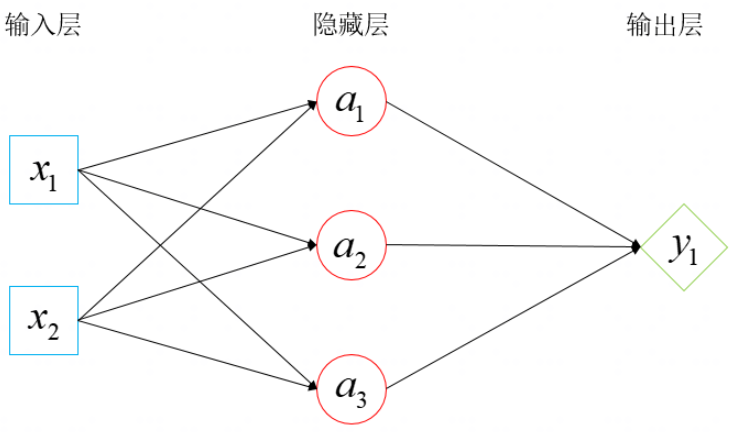

### 2.1 正向传播

$$z^{[1]} = \left\lgroup\begin{matrix}z_{1}^{[1]} \cr z_{2}^{[2]} \cr z_{3}^{[3]}\end{matrix}\right\rgroup = \left\lgroup\begin{matrix}w_{1}^{[1]T}\cdot x + b_{1}^{[1]} \cr w_{2}^{[2]T}\cdot x + b_{2}^{[2]} \cr w_{3}^{[3]T}\cdot x + b_{3}^{[3]}\end{matrix}\right\rgroup = \left\lgroup\begin{matrix}w_{1}^{[1]T}\cdot x \cr w_{2}^{[2]T}\cdot x \cr w_{3}^{[3]T}\cdot x  \end{matrix}\right\rgroup + b^{[1]} = W^{[1]}X + b^{[1]}$$



$$a^{[1]} = \left\lgroup\begin{matrix}a_{1}^{[1]} \cr a_{2}^{[2]} \cr a_{3}^{[3]}\end{matrix}\right\rgroup = \left\lgroup\begin{matrix}t\left(z_{1}^{[1]}\right) \cr t\left(z_{2}^{[2]}\right) \cr t\left(z_{3}^{[3]}\right)\end{matrix}\right\rgroup = t\left\lgroup\begin{matrix}\left(z_{1}^{[1]}\right) \cr \left(z_{2}^{[2]}\right) \cr \left(z_{3}^{[3]}\right) \end{matrix}\right\rgroup = t\left(z^{[1]}\right)$$

- 上角标中括号用于区分不同层
- 下角标数字表示神经元节点的映射关系
- 一个神经元节点包含上一层节点数$w$和$b$和下一层节点数$z$

### 2.2 反向传播

梯度下降法：

$$W = W - \alpha  \frac{\partial L}{\partial W}$$
$$b = b - \alpha  \frac{\partial L}{\partial b}$$

式中$W$和$b$为模型的权重参数，$L$为模型定义的损失函数，$\alpha$为超参数学习率；以上两式可以理解为：通过损失函数$L$对权重参数$W$和$b$进行求取导数，并利用导数乘以学习率对原来的$W$和$b$进行更新。

## 3、实验环境

- MindSpore 2.0（MindSpore版本会定期更新，本指导也会定期刷新，与版本配套）；
- 本案例支持win_x86和Linux系统，CPU/Ascend均可运行。
- 如果在本地运行此实验，请参考《MindSpore环境搭建实验手册》在本地安装MindSpore。

## 4、数据处理

### 4.1数据准备

这个数据集来自卡内基梅隆大学维护的StatLib库。1983年美国统计协会博览会使用了该数据集。这个数据集是对StatLib库中提供的数据集稍加修改的版本。根据Ross Quinlan(1993)在预测属性“mpg”中的使用，删除了 8 个原始实例，因为它们的“mpg”属性值未知。原始数据集在“auto-mpg.data-original”文件中。

该数据集共计9个特征，398个样本，用于回归任务。

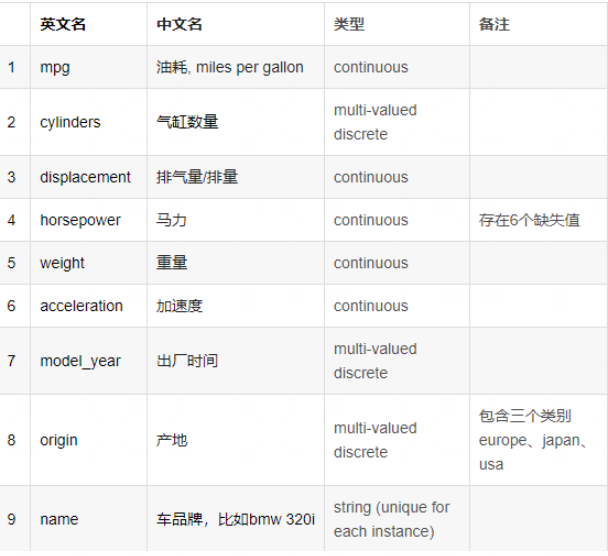

In [1]:
from download import download

# 下载汽车里程auto-mpg数据集
url = " https://ascend-professional-construction-dataset.obs.cn-north-4.myhuaweicloud.com:443/deep-learning/auto-mpg.zip"  
path = download(url, "./", kind="zip", replace=True)


file_sizes: 100%|██████████████████████████| 6.68k/6.68k [00:00<00:00, 1.12MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./


### 4.2数据加载

- 导入模型库：

os模块主要用于对系统路径和文件进行处理。Numpy模块主要用于数据的基本运算操作。Matplotlib模块主要用于画图。MindSpore相关模块主要用于搭建网络、调用优化器、读取数据集和将数据集处理成网络的标准输入格式。

In [2]:
#导入相关依赖库
import  os
import csv
import time
import numpy as np
import pandas as pd  #版本采用1.3.0
from matplotlib import pyplot as plt

import mindspore as ms
import mindspore.dataset as ds
from mindspore.dataset import GeneratorDataset
import mindspore.context as context
import mindspore.dataset.transforms as C
import mindspore.dataset.vision as CV

from mindspore import nn, Tensor, ops
from mindspore.train import Model
from mindspore.train import Accuracy, MAE, MSE
from mindspore import load_checkpoint, load_param_into_net
from mindspore.train import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor

context.set_context(mode=context.GRAPH_MODE, device_target='CPU')  # device_target支持"Ascend"、"CPU"。

- 查看数据格式

In [3]:
#加载数据集
with open('./auto-mpg.data') as csv_file:
    data = list(csv.reader(csv_file, delimiter=','))
print(data[20:40]) # 打印部分数据

[['25.0   4   110.0      87.00      2672.      17.5   70  2\t"peugeot 504"'], ['24.0   4   107.0      90.00      2430.      14.5   70  2\t"audi 100 ls"'], ['25.0   4   104.0      95.00      2375.      17.5   70  2\t"saab 99e"'], ['26.0   4   121.0      113.0      2234.      12.5   70  2\t"bmw 2002"'], ['21.0   6   199.0      90.00      2648.      15.0   70  1\t"amc gremlin"'], ['10.0   8   360.0      215.0      4615.      14.0   70  1\t"ford f250"'], ['10.0   8   307.0      200.0      4376.      15.0   70  1\t"chevy c20"'], ['11.0   8   318.0      210.0      4382.      13.5   70  1\t"dodge d200"'], ['9.0    8   304.0      193.0      4732.      18.5   70  1\t"hi 1200d"'], ['27.0   4   97.00      88.00      2130.      14.5   71  3\t"datsun pl510"'], ['28.0   4   140.0      90.00      2264.      15.5   71  1\t"chevrolet vega 2300"'], ['25.0   4   113.0      95.00      2228.      14.0   71  3\t"toyota corona"'], ['25.0   4   98.00      ?          2046.      19.0   71  1\t"ford pinto"'], ['

- 利用pandas模块读取数据

Pandas模块是一个处理表格类数据非常有效的模块。

In [4]:
#使用pandas读取数据
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
#遇到？换成nan，忽略\t之后的内容，已空格作为分隔符。
raw_data = pd.read_csv('./auto-mpg.data', names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

data = raw_data.copy()

#查看数据形状
data.shape

(398, 8)

- 数据预处理

对于数据集中的空值，我们要在建模前进行处理。此处空值的数据较少，我们直接进行删除。特征Origin代表着车辆的归属区域信息，此处总共分为三种，欧洲，美国，日本，我们需要对此特征进行one-hot编码。

In [5]:
#对于数据集中的空值，我们要在建模前进行处理。此处空值的数据较少，我们直接进行删除。
#清洗空数据
data = data.dropna()
data.tail()
#Pandas库提供了简单的数据集统计信息，我们可直接调用函数describe()进行查看。
#查看训练数据集的结构
origin = data.pop('Origin')
data_labels = data.pop('MPG')
train_stats = data.describe()
train_stats = train_stats.transpose()
train_stats
#归一化数据
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_data = norm(data)
# 将MPG放回归一化后的数据中
normed_data['MPG'] = data_labels
# 离散特征处理
# 特征Origin代表着车辆的归属区域信息，此处总共分为三种，欧洲，美国，日本，我们需要对此特征进行one-hot编码。
# 对origin属性进行one-hot编码
normed_data['USA'] = (origin == 1)*1.0
normed_data['Europe'] = (origin == 2)*1.0
normed_data['Japan'] = (origin == 3)*1.0

模型训练需要区分特征值与目标值，也就是我们常说的X值与Y值，此处MPG为Y值，其余的特征为X值。

在模型构建的时候，我们一般需要准备两份数据，一份训练集数据用于模型的训练构建，一份测试集用于模型的评估优化。创建比例0.8，用于分割训练集和验证集，80%的数据用于模型训练，20%的数据用于模型验证。并把数据集处理成模型所需的数据格式。

In [6]:
#将数据集按照4：1划分成训练集和测试集
train_dataset = normed_data.sample(frac=0.8,random_state=0)
test_dataset = normed_data.drop(train_dataset.index)

#模型训练需要区分特征值与目标值，也就是我们常说的X值与Y值，此处MPG为Y值，其余的特征为X值。
#将目标值和特征分开
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

X_train, Y_train = np.array(train_dataset), np.array(train_labels)
X_test, Y_test = np.array(test_dataset), np.array(test_labels)

#查看数据集尺寸
print('训练数据x尺寸：',X_train.shape)
print('训练数据y尺寸：',Y_train.shape)
print('测试数据x尺寸：',X_test.shape)
print('测试数据y尺寸：',Y_test.shape)
#将数据集转换为Tensor格式
ds_xtrain= Tensor(X_train, ms.float32)
print(ds_xtrain[2])
ds_ytrain= Tensor(Y_train, ms.int32)[:, np.newaxis]
print(ds_ytrain[2])


ds_xtest=Tensor(X_test, ms.float32)
ds_ytest=Tensor(Y_test, ms.int32)

训练数据x尺寸： (314, 9)
训练数据y尺寸： (314,)
测试数据x尺寸： (78, 9)
测试数据y尺寸： (78,)
[ 1.482053    1.4868315   1.4426848   1.7405361  -0.73991555 -1.0803139
  1.          0.          0.        ]
[12]


In [7]:
# Iterable object as input source
class Iterable:
    def __init__(self, X_train, Y_train):
        self._data = X_train
        self._label = Y_train[:, np.newaxis]

    def __getitem__(self, index):
        return self._data[index], self._label[index]

    def __len__(self):
        return len(self._data)

data = Iterable(X_train, Y_train)
print(type(data))
dataset_train = GeneratorDataset(source=data, column_names=["data", "label"])
print(type(dataset_train))
print(list(dataset_train.create_tuple_iterator())[2])

<class '__main__.Iterable'>
<class 'mindspore.dataset.engine.datasets_user_defined.GeneratorDataset'>
[Tensor(shape=[9], dtype=Float64, value= [ 1.48205303e+00,  1.18103289e+00,  9.23084997e-01,  1.29787202e+00, -6.67421972e-01,  5.48467063e-01,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00]), Tensor(shape=[1], dtype=Float64, value= [ 1.75000000e+01])]


## 5、模型构建

汽车油耗里程数据集准备完成，接下来我们就需要构建训练模型，本实验采用的是全连接神经网络算法，所以我们首先需要建立初始化的神经网络。nn.cell能够用来组成网络模型;模型共包含3个全连接，采用Relu当做激活函数。

In [8]:
# 定义网络
class Regression_car(nn.Cell):
    def __init__(self):
        super(Regression_car, self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.fc1 = nn.Dense(9,64, activation='relu')
        self.fc2 = nn.Dense(64,64, activation='relu')
        self.fc3 = nn.Dense(64,1)
        
        
    def construct(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

## 6、模型训练

指定模型所需的损失函数、评估指标、优化器等参数。回归问题，损失函数采用均方误差MSE。将创建好的网络、损失函数、评估指标、优化器等参数装入模型中对模型进行训练。需要逐步打印出MAE、MSE的值。

In [9]:
#定义网络，损失函数，评估指标  优化器
network = Regression_car()
net_loss = nn.MSELoss()
net_opt = nn.RMSProp(network.trainable_params(), 0.001)

# 定义用于训练的train_loop函数。
def train_loop(model, dataset, loss_fn, optimizer):
    # 定义正向计算函数
    def forward_fn(data, label):
        logits = model(data)
        loss = loss_fn(logits, label)
        return loss, logits

    # 定义自动微分函数，使用mindspore.value_and_grad获得微分函数grad_fn。
    grad_fn = ms.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

    # 定义 one-step training函数
    def train_step(data, label):
        (loss, _), grads = grad_fn(data, label)
        loss = ops.depend(loss, optimizer(grads))
        return loss

    size = dataset.get_dataset_size()
    model.set_train()
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        # 将喂给网络的数据转置，使其满足网络所需的数据结构
        data, label = ms.Tensor(data[:, np.newaxis].T, ms.float32), ms.Tensor(label[:, np.newaxis], ms.float32)
        #print(data.shape,label.shape)
        loss = train_step(data.astype(np.float32), label.astype(np.float32))

    return loss

#WithEvalCell返回loss、输出和标签的单元，用于评估。此单元接受网络和loss函数作为参数，并计算模型的loss。它返回loss、输出和标签来计算度量。
evalcell=nn.WithEvalCell(network,net_loss)
#创建指标类

mae = nn.MAE()
mse = nn.MSE()
val_mae = nn.MAE()
val_mse = nn.MSE()

#创建一个空的Dataframe
result =pd.DataFrame(columns=('_epoch','_loss','_mae','_mse','val_mae','val_mse'))
print("============== Starting Training ==============")
epochs = 100
for epoch in range(epochs):
    #print(f"Epoch {epoch+1}\n-------------------------------")
    loss = train_loop(network, dataset_train, net_loss, net_opt)
    #print(loss)
    #利用evalcell接收训练集获取训练过程的输出用于计算mae和mse，接收测试集获取测试集输出
    _, outputs, label = evalcell(ds_xtrain,ds_ytrain)
    _, val_outputs, val_label = evalcell(ds_xtest,ds_ytest)
    
    #每次循环都更新MAE、MSE等的值。
    mae.clear()
    mae.update(outputs, label)
    mse.clear()
    mse.update(outputs, label)
    val_mae.clear()
    val_mae.update(val_outputs, val_label)
    val_mse.clear()
    val_mse.update(val_outputs, val_label)
    
    Mae = mae.eval()
    Mse = mse.eval()
    Val_Mae = val_mae.eval()
    Val_Mse = val_mse.eval()
    
    nd_loss = loss.asnumpy()
    fl_loss = float(nd_loss)/24.0

    #将计算结果逐行插入result,注意变量要用[]括起来,同时ignore_index=True，否则会报错，ValueError: If using all scalar values, you must pass an index
    
    result=result.append(pd.DataFrame({'_epoch':[epoch],'_loss':fl_loss,'_mae':Mae,'_mse':Mse,
                                       'val_mae':Val_Mae,'val_mse':Val_Mse}),ignore_index=True)

    if epoch%10==0:
        print('epoch:{0},loss:{1},mae:{2},mse:{3},val_mae:{4},val_mse:{5}'.format(epoch,fl_loss,Mae,Mse,
                                                                                               Val_Mae,Val_Mse))
        print("*" * 110)
print(result)

============== Starting Training ==============
epoch:0,loss:0.41511861483256024,mae:2.854155327863754,mse:13.379231391314082,val_mae:2.5668101066198106,val_mse:11.28566952638405
**************************************************************************************************************
epoch:10,loss:1.071864366531372,mae:2.0573466720095106,mse:8.221336264521343,val_mae:2.144106754889855,val_mse:7.915761490005806
**************************************************************************************************************
epoch:20,loss:0.10866741339365642,mae:2.0427963171794916,mse:7.895773526207009,val_mae:2.236280172299116,val_mse:8.009133257665338
**************************************************************************************************************
epoch:30,loss:0.43054529031117755,mae:1.883006463384932,mse:7.162816159641572,val_mae:1.8261689283908942,val_mse:6.1017134810154765
************************************************************************************************

## 7、模型预测

绘制模型损失函数图，利用result中的MAE和MSE查看模型训练状态。

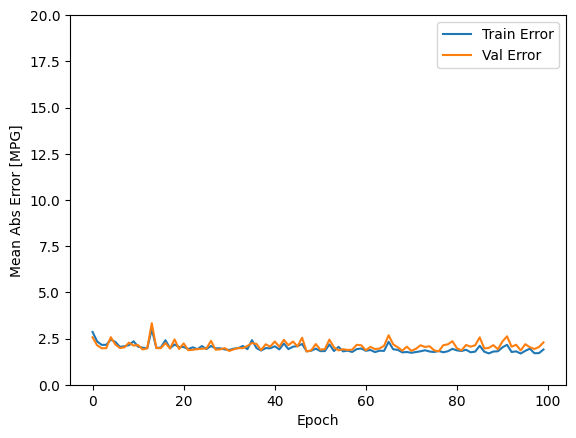

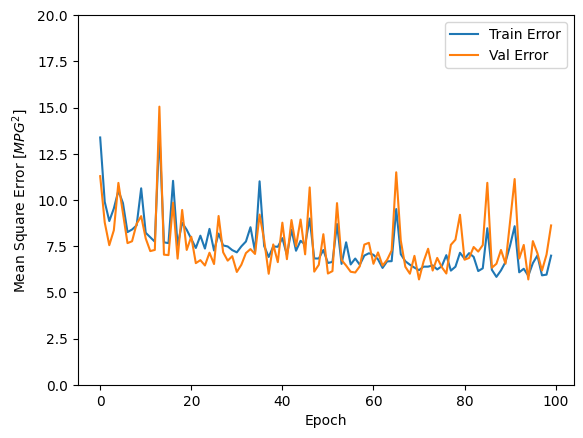

In [10]:
#绘制模型损失函数图
def plot_history(result):

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(result['_epoch'], result['_mae'],
           label='Train Error')
    plt.plot(result['_epoch'], result['val_mae'],
           label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(result['_epoch'], result['_mse'],
           label='Train Error')
    plt.plot(result['_epoch'], result['val_mse'],
           label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()


plot_history(result)